In [ ]:
!pip install plot_model

In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.4 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
#!pip uninstall tensorflow
#!pip install --ignore-installed --upgrade tensorflow

In [ ]:
#!pip install --user tensorflow
#!pip install --user keras
!pip install pydotplus
!pip install graphviz

In [ ]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [ ]:
#!pip show keras

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px

import os
import keras
#import tensorflow.python.keras.utils.vis_utils
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import OneHotEncoder, label_binarize

import tensorflow_addons as tfa
#from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model
from tqdm import tqdm

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from xgboost import XGBClassifier # XGBClassifier


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Downloading files
# Four categories
non_demented = []
very_mild_demented = []
mild_demented = []
moderate_demented = []

# Download per category
for dirname, _, filenames in os.walk('/content/drive/MyDrive/OASIS Alzheimer_s Dataset/Non Demented'):
    for filename in filenames:
        non_demented.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('/content/drive/MyDrive/OASIS Alzheimer_s Dataset/Very mild Dementia'):
    for filename in filenames:
        very_mild_demented.append(os.path.join(dirname, filename))
for dirname, _, filenames in os.walk('/content/drive/MyDrive/OASIS Alzheimer_s Dataset/Mild Dementia'):
    for filename in filenames:
        mild_demented.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('/content/drive/MyDrive/OASIS Alzheimer_s Dataset/Moderate Dementia'):
    for filename in filenames:
        moderate_demented.append(os.path.join(dirname, filename))

In [ ]:
# How many samples in each category:
print(len(non_demented))
print(len(very_mild_demented))
print(len(mild_demented))
print(len(moderate_demented))

66877
7073
5002
488


<Figure size 1500x500 with 0 Axes>

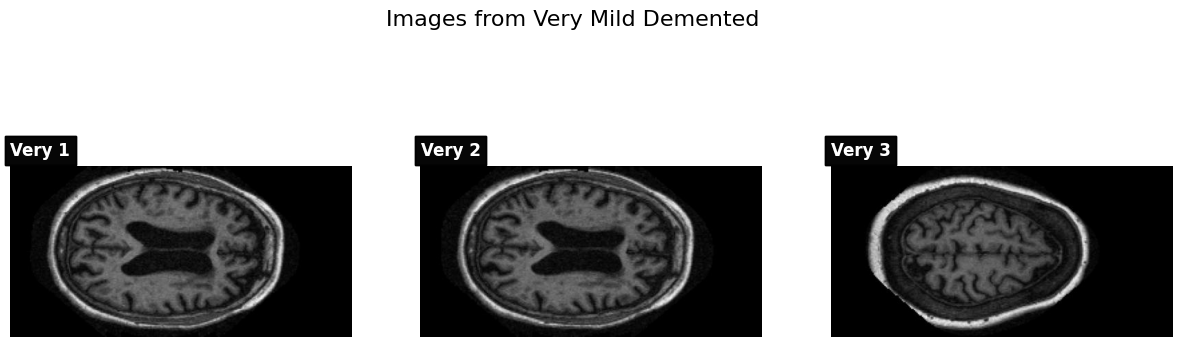

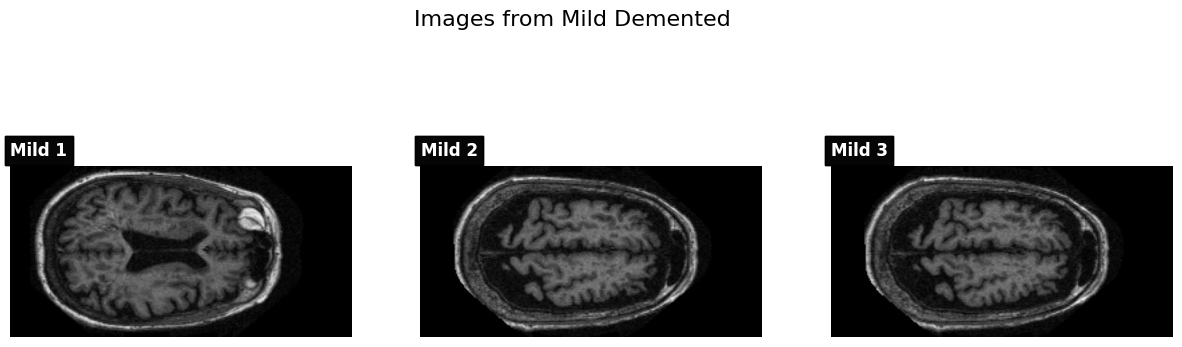

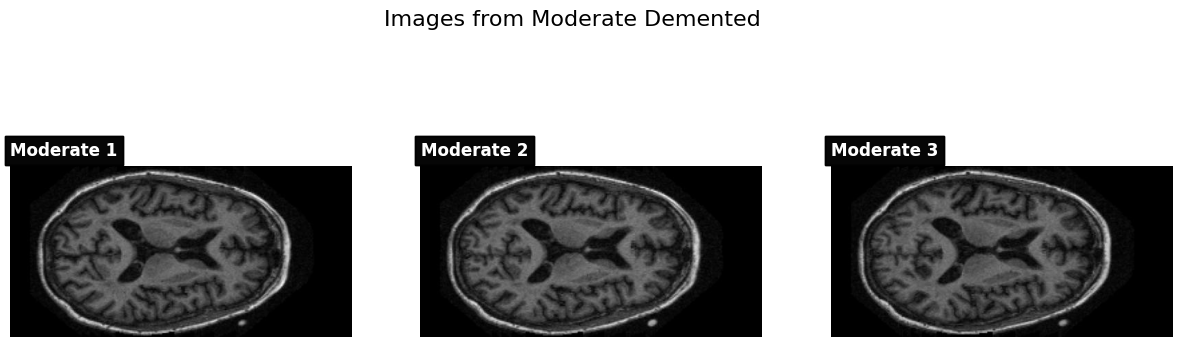

In [ ]:
# Function to display images with text indicating the category
def display_images_with_text(file_paths, category_name, endings=['150', '151', '152']):
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Images from {category_name}", fontsize=16)

    for ending in endings:
        matching_files = [img for img in file_paths if img.endswith(ending + '.jpg')]
        for i in range(min(3, len(matching_files))):
            img_path = matching_files[i]
            img = Image.open(img_path)
            plt.subplot(1, 3, i + 1)
            plt.imshow(img)
            plt.axis('off')
             # Add text indicating the category
            plt.text(0, -10, f"{category_name.split()[0]} {i + 1}", color='white', fontsize=12, weight='bold', ha='left', va='bottom', bbox=dict(facecolor='black', alpha=0.7))

    plt.show()

# Display images with text for each category
display_images_with_text(non_demented, "Non Demented")
display_images_with_text(very_mild_demented, "Very Mild Demented")
display_images_with_text(mild_demented, "Mild Demented")
display_images_with_text(moderate_demented, "Moderate Demented")


In [ ]:
def validate_filename(filename):
    """
    Validate filename to ensure it is a valid OASIS Alzheimer's dataset filename.
    """
    pattern = re.compile('OAS1_\d+_MR\d+_mpr-\d+_\d+.jpg')
    return bool(pattern.match(filename))

In [ ]:
import re
def get_info_from_filename(filename):
    pattern = re.compile('OAS1_(\d+)_MR(\d+)_mpr-(\d+)_(\d+).jpg')
    match = pattern.match(filename)
    patient_id = match.group(1)
    mr_id = match.group(2)
    scan_id = match.group(3)
    layer_id = match.group(4)

    return patient_id, mr_id, scan_id, layer_id

In [ ]:
def create_ref_df(dataset_path):
    paths, labels = [], []
    patient_ids, mr_ids, scan_ids, layer_ids = [], [], [], []

    # Iterate through folders in the dataset_path
    for folder in os.listdir(dataset_path):

        # Iterate through files in each folder
        for file in os.listdir(os.path.join(dataset_path, folder)):
            if not validate_filename(file):
                raise ValueError(f'Invalid filename: {folder}/{file}')
            # Extract information from the filename using get_info_from_filename function
            patient_id, mr_id, scan_id, layer_id = get_info_from_filename(file)

             # Append information to respective lists
            paths.append(os.path.join(dataset_path, folder, file))
            labels.append(folder)
            patient_ids.append(patient_id)
            mr_ids.append(mr_id)
            scan_ids.append(scan_id)
            layer_ids.append(layer_id)

             # Create a DataFrame from the collected information
    ref_df = pd.DataFrame({
        'path': paths,
        'label': labels,
        'patient_id': patient_ids,
        'mr_id': mr_ids,
        'scan_id': scan_ids,
        'layer_id': layer_ids
    })
# Convert columns to appropriate data types
    ref_df = ref_df.astype({
        'path': 'string',
        'label': 'string',
        'patient_id': 'string',
        'mr_id': 'string',
        'scan_id': 'string',
        'layer_id': 'string'
    })

    return ref_df

In [ ]:
# Applying the function defined above
ref_df = create_ref_df('/content/drive/MyDrive/OASIS Alzheimer_s Dataset')

In [ ]:
# displaying the DataFrame
display(ref_df)

,path,label,patient_id,mr_id,scan_id,layer_id
0,/content/drive/MyDrive/OASIS Alzheimer_s Datas...,Mild Dementia,0278,1,4,137
1,/content/drive/MyDrive/OASIS Alzheimer_s Datas...,Mild Dementia,0278,1,4,141
2,/content/drive/MyDrive/OASIS Alzheimer_s Datas...,Mild Dementia,0278,1,4,133
3,/content/drive/MyDrive/OASIS Alzheimer_s Datas...,Mild Dementia,0278,1,4,151
4,/content/drive/MyDrive/OASIS Alzheimer_s Datas...,Mild Dementia,0278,1,4,140
...,...,...,...,...,...,...
79435,/content/drive/MyDrive/OASIS Alzheimer_s Datas...,Very mild Dementia,0003,1,1,150
79436,/content/drive/MyDrive/OASIS Alzheimer_s Datas...,Very mild Dementia,0003,1,1,154
79437,/content/drive/MyDrive/OASIS Alzheimer_s Datas...,Very mild Dementia,0003,1,1,141
79438,/content/drive/MyDrive/OASIS Alzheimer_s Datas...,Very mild Dementia,0003,1,2,102


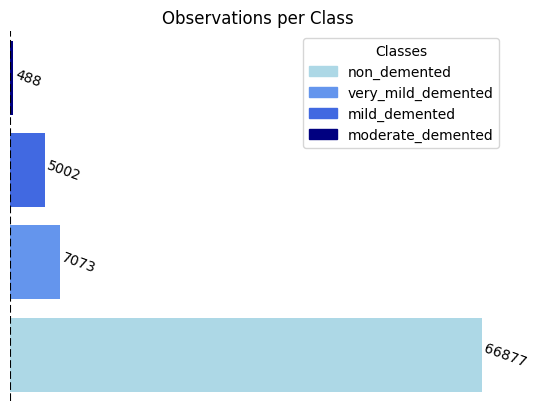

In [ ]:
 #Label Distribution

 # Defining class_names, frequencies
frequencies = [len(non_demented),  len(very_mild_demented), len(moderate_demented), len(mild_demented),]
class_names = ["non_demented", "very_mild_demented", "moderate_demented", "mild_demented"]

# Sorting class_names and frequencies in descending order
sorted_indices = np.argsort(frequencies)[::-1]
class_names = np.array(class_names)[sorted_indices]
frequencies = np.array(frequencies)[sorted_indices]

# Navy blue gradient color palette with 4 distinct colors
navy_blue_palette = LinearSegmentedColormap.from_list("navy_blue_palette", ["lightblue", "cornflowerblue", "royalblue", "navy"], N=4)

# Bar plot with adjusted y-axis limits and navy blue gradient colors
fig, ax = plt.subplots()
bp = ax.barh(np.arange(len(class_names)), frequencies, color=navy_blue_palette(np.linspace(0, 1, len(class_names))))

# Adjusted y-axis limits
ax.set_ylim(-0.5, len(class_names)-0.5)

# Class names as y-axis labels
ax.set_yticks(np.arange(len(class_names)))
ax.set_yticklabels(class_names)

# Hide axes
ax.axis('off')

# Frequency values to the right of each bar with a reduced offset
for i, frequency in enumerate(frequencies):
    ax.text(frequency + 0.1, i, frequency, ha='left', va='center', rotation=-20)

# Vertical line at 0 for clarity
ax.axvline(x=0, linestyle='--', color='black')

# Legend
handles = [plt.Rectangle((0, 0), 1, 1, color=navy_blue_palette(i)) for i in range(4)]
ax.legend(handles, class_names, loc="upper right", title="Classes")

# Plot title
plt.title("Observations per Class")

plt.show()

In [ ]:
#Data Pre-Processing
#Splitting Off a Test Set
from sklearn.model_selection import train_test_split
# Set seed for random sampling
random.seed(42)


 # Split off a test set for the moderate_demented class
moderate_demented_train, moderate_demented_test = train_test_split(
    moderate_demented, test_size=0.2, random_state=42)

# Split off a test set for the mild_demented class
mild_demented_train, mild_demented_test = train_test_split(
    mild_demented, test_size=0.2, random_state=42
)

# Split off a test set for the very_mild_demented class
very_mild_demented_train, very_mild_demented_test = train_test_split(
    very_mild_demented, test_size=0.2, random_state=42
)

# Split off a test set for the non_demented class
non_demented_train, non_demented_test = train_test_split(
    non_demented, test_size=0.2, random_state=42
)

In [ ]:
# Check number of train images per category
print(len(non_demented_train))
print(len(very_mild_demented_train))
print(len(mild_demented_train))
print(len(moderate_demented_train))

53501
5658
4001
390


In [ ]:
# Specify the target number of samples for each class
target_samples = 5000

# Oversample small classes
moderate_demented_samp = random.choices(moderate_demented_train, k=target_samples)
mild_demented_samp = random.choices(mild_demented_train, k=target_samples)

# Undersample large classes
very_mild_demented_samp = random.sample(very_mild_demented_train, k=target_samples)
non_demented_samp = random.sample(non_demented_train, k=target_samples)

In [ ]:
# Check results
print(len(non_demented_samp))
print(len(very_mild_demented_samp))
print(len(mild_demented_samp))
print(len(moderate_demented_samp))

5000
5000
5000
5000


In [ ]:
#Undersampling Test Data
# Check the number of test images per category
print(len(non_demented_test))
print(len(very_mild_demented_test))
print(len(mild_demented_test))
print(len(moderate_demented_test))


13376
1415
1001
98


In [ ]:
# Specify the target number of samples for each class
target_samples = 640

#Undersample large classes
mild_demented_test = random.sample(mild_demented_test, k=target_samples)
very_mild_demented_test = random.sample(very_mild_demented_test, k=target_samples)
non_demented_test = random.sample(non_demented_test, k=target_samples)

In [ ]:
print(len(non_demented_test))
print(len(very_mild_demented_test))
print(len(mild_demented_test))
print(len(moderate_demented_test))

640
640
640
98


In [ ]:
#Merging, Shaping, Splitting
#1One-Hot Encoder

# One-hot encoder for class labels
encoder = OneHotEncoder()
encoder.fit([[0],[1],[2],[3]])

OneHotEncoder()

In [ ]:
# Empty objects to store the data and the class labels (result) in
data = []
result = []

# Loop through each category and transform data and result into right format (128x128x3 & one-hot encoded)
# and merge categories together
for path in non_demented_samp:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[0]]).toarray())

for path in very_mild_demented_samp:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[1]]).toarray())


for path in mild_demented_samp:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[2]]).toarray())


for path in moderate_demented_samp:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        result.append(encoder.transform([[3]]).toarray())

In [ ]:
# Transform data to numpy array
data = np.array(data)

# Check shape
data.shape

(20000, 128, 128, 3)

In [ ]:
# Transform labels to numpy array
result = np.array(result)

# Reshape to the one-hot encoded format
result = result.reshape((data.shape[0],4))

# Check shape
result.shape

(20000, 4)

In [ ]:
# Save the numpy array
np.save('/content/drive/MyDrive/Alzheimer_s Dataset/TrainData_array.npy', data)
np.save('/content/drive/MyDrive/Alzheimer_s Dataset/trainresult_array.npy', result)

In [ ]:
import numpy as np

# Load the NumPy array file
file_path = '/content/drive/MyDrive/Alzheimer_s Dataset/TrainData_array.npy'
data = np.load(file_path)

# Check the shape of the loaded array
print("Loaded array shape:", data.shape)

Loaded array shape: (20000, 128, 128, 3)


In [ ]:
import numpy as np

# Load the NumPy array file
file_path = '/content/drive/MyDrive/Alzheimer_s Dataset/trainresult_array.npy'
result = np.load(file_path)

# Check the shape of the loaded array
print("Loaded array shape:", result.shape)

Loaded array shape: (20000, 1, 4)


In [ ]:
# Transform labels to numpy array
result = np.array(result)

# Reshape to the one-hot encoded format
result = result.reshape((data.shape[0],4))

# Check shape
result.shape

(20000, 4)

In [ ]:
x_train = data
y_train = result

In [ ]:
# Split in validation and train data
x_train,x_val,y_train,y_val = train_test_split(data,result, test_size=0.20, shuffle=True, random_state=42)

In [ ]:
x_train.shape

(16000, 128, 128, 3)

In [ ]:
x_val.shape

(4000, 128, 128, 3)

In [ ]:
### Transforming the data into the right shape (128x128x3), merge and encode it

data_test = []
result_test = []

for path in non_demented_test:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data_test.append(np.array(img))
        result_test.append(encoder.transform([[0]]).toarray())

for path in very_mild_demented_test:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data_test.append(np.array(img))
        result_test.append(encoder.transform([[1]]).toarray())

for path in mild_demented_test:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data_test.append(np.array(img))
        result_test.append(encoder.transform([[2]]).toarray())

for path in moderate_demented_test:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data_test.append(np.array(img))
        result_test.append(encoder.transform([[3]]).toarray())

In [ ]:
# Transform data to numpy array
data_test = np.array(data_test)
data_test.shape

(2018, 128, 128, 3)

In [ ]:
# Transform labels to numpy array
result_test = np.array(result_test)
result_test = result_test.reshape((data_test.shape[0],4))
result_test.shape

(2018, 4)

In [ ]:
# Save the numpy array
np.save('/content/drive/MyDrive/Alzheimer_s Dataset/TestData_array.npy', data_test)
np.save('/content/drive/MyDrive/Alzheimer_s Dataset/Testresult_array.npy', result_test)

In [ ]:
# Save the numpy array
np.save('/content/drive/MyDrive/Alzheimer_s Dataset/TestData_array_overSmp.npy', data_test)
np.save('/content/drive/MyDrive/Alzheimer_s Dataset/Testresult_array_overSmp.npy', result_test)

In [ ]:
import numpy as np

# Load the NumPy array file
file_path = '/content/drive/MyDrive/Alzheimer_s Dataset/TestData_array.npy'
data_test = np.load(file_path)

# Check the shape of the loaded array
print("Loaded array shape:", data_test.shape)

Loaded array shape: (15890, 128, 128, 3)


In [ ]:
import numpy as np

# Load the NumPy array file
file_path = '/content/drive/MyDrive/Alzheimer_s Dataset/Testresult_array.npy'
result_test = np.load(file_path)

# Check the shape of the loaded array
print("Loaded array shape:", result_test.shape)

Loaded array shape: (15890, 4)


In [ ]:
# Change names to x_test and y_test
x_test = data_test
y_test = result_test
y_test.shape

(15890, 4)

The data pre-processing thus resulted in the following data objects:

x_train: train data

y_train: train labels

x_val: validation data (used in training/modeling)

y_val: validation labels (used in training/modeling)

x_test: test data (evaluation after modeling)

y_test: test labels (evaluation after modeling)


In [ ]:
# Convert labels to integers
y_train_int = np.argmax(y_train, axis=1)
y_val_int = np.argmax(y_val, axis=1)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the ImageDataGenerator with desired augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=10,          # Rotate images randomly by up to 10 degrees
    width_shift_range=0.1,      # Shift images horizontally by up to 10% of the width
    height_shift_range=0.1,     # Shift images vertically by up to 10% of the height
    shear_range=0.1,            # Apply shear transformation with a maximum shear angle of 10%
    zoom_range=0.1,             # Zoom in or out of images by up to 10%
    horizontal_flip=True,       # Flip images horizontally (left to right) randomly
    vertical_flip=False,         # Flip images vertically (top to bottom) randomly
    fill_mode='nearest'         # Fill in newly created pixels after rotation or shifting
)

In [ ]:
# Fit the ImageDataGenerator to your training data
datagen.fit(x_train)

In [ ]:
# Create augmented data batches during training
batch_size = 32
# Apply data augmentation to the training data
augmented_data = datagen.flow(x_train, y_train, batch_size=batch_size)

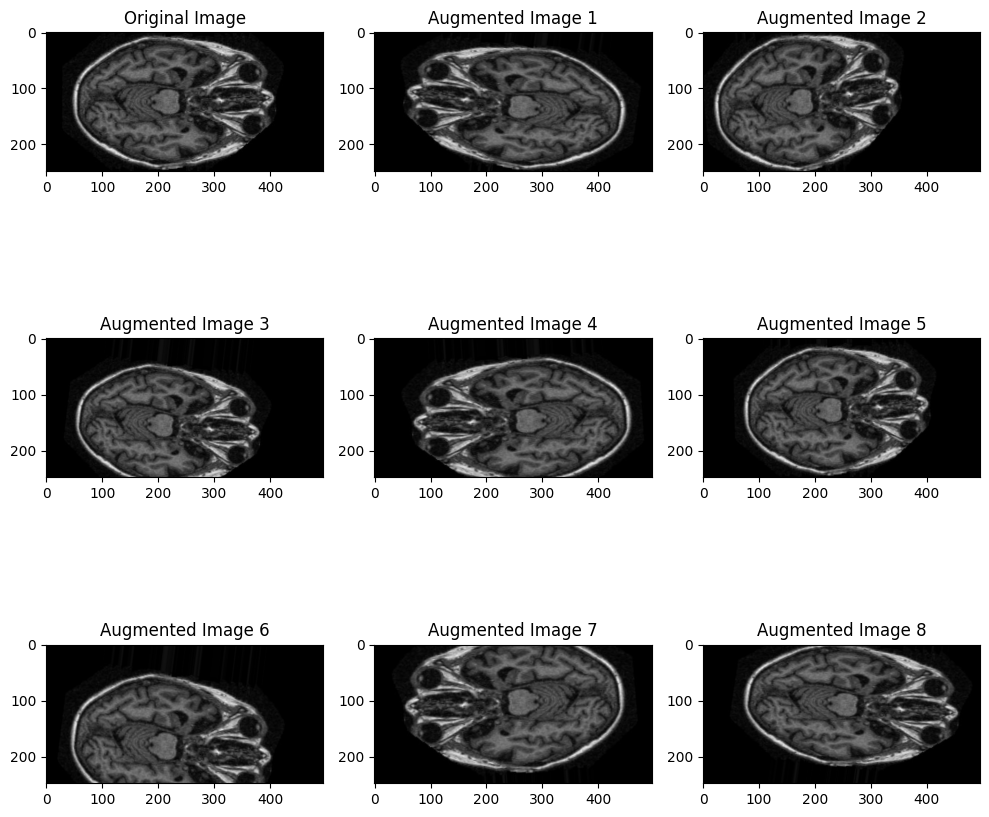

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

# Load a sample image
img = Image.open("/content/drive/MyDrive/OASIS Alzheimer_s Dataset/Very mild Dementia/OAS1_0003_MR1_mpr-1_136.jpg")
img_array = np.array(img)

# Create an ImageDataGenerator with specified augmentation settings
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

# Generate augmented images
augmented_images = []
for i in range(9):  # Generate 9 augmented images
    augmented_img = datagen.random_transform(img_array)
    augmented_images.append(augmented_img)

# Plot the original and augmented images
plt.figure(figsize=(10, 10))
plt.subplot(3, 3, 1)
plt.imshow(img)
plt.title('Original Image')

for i in range(8):
    plt.subplot(3, 3, i + 2)
    plt.imshow(augmented_images[i])
    plt.title(f'Augmented Image {i + 1}')

plt.tight_layout()
plt.show()

In [ ]:
inception_model = InceptionV3(input_shape=(128, 128, 3), include_top=False, weights="imagenet")

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
for layer in inception_model.layers:
  layer.trainable= False

In [ ]:
inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 63, 63, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 63, 63, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 63, 63, 32)           0         ['batch_normalizati

In [ ]:
custom_inception_model = Sequential([
      inception_model,
      Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4) #'Dense(4,activation='softmax')
      ], name = "inception_cnn_model")

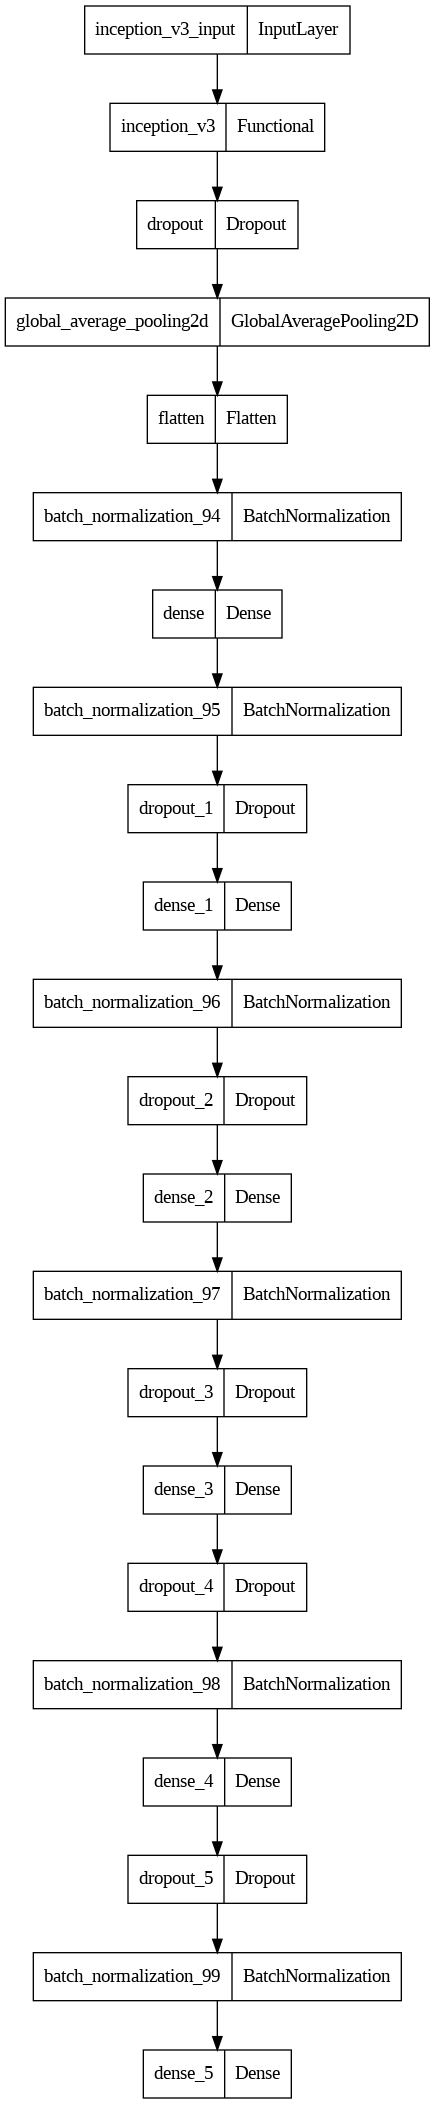

In [ ]:
plot_model(custom_inception_model)

In [ ]:
'''# Define early stopping callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
# Adam optimizer with learning rate 0.001
optimizer = Adam(learning_rate=0.001)

# Compile the model
custom_inception_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, restore_best_weights=True)

In [ ]:
'''#Fit the training data to the model and validate it using the validation data
# Convert labels to integers

EPOCHS = 20
history = custom_inception_model.fit(x_train, y_train_int, validation_data=(x_val, y_val_int), callbacks=[early_stopping],epochs=EPOCHS)

# Train the model with early stopping
#history_EfficientNetB0 = model_EfficientNetB0.fit(x_train, y_train_int, epochs=50, batch_size=16,verbose=1, validation_data=(x_val, y_val_int), callbacks=[early_stopping])

Training: Regular Classification

In [ ]:
from tensorflow.keras.models import clone_model
custom_inception_model_rc = clone_model(custom_inception_model)

In [ ]:
# Compile with ('regular') categorical_crossentropy
# Adam optimizer with learning rate 0.001
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
custom_inception_model_rc.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, restore_best_weights=True)

In [ ]:
EPOCHS = 30
history_rc = custom_inception_model_rc.fit(x_train, y_train, validation_data=(x_val, y_val), callbacks=[early_stopping],epochs=EPOCHS)

Epoch 1/30
500/500 [==============================] - 151s 287ms/step - loss: 6.2227 - accuracy: 0.2499 - val_loss: 4.9321 - val_accuracy: 0.2560
Epoch 2/30
500/500 [==============================] - 143s 286ms/step - loss: 5.9915 - accuracy: 0.2479 - val_loss: 4.9310 - val_accuracy: 0.2553
Epoch 3/30
500/500 [==============================] - 140s 281ms/step - loss: 5.6874 - accuracy: 0.2531 - val_loss: 5.9953 - val_accuracy: 0.2533
Epoch 4/30
500/500 [==============================] - 142s 284ms/step - loss: 5.3462 - accuracy: 0.2475 - val_loss: 5.0171 - val_accuracy: 0.2425
Epoch 5/30
500/500 [==============================] - 141s 282ms/step - loss: 5.0385 - accuracy: 0.2524 - val_loss: 4.4314 - val_accuracy: 0.2715
Epoch 6/30
500/500 [==============================] - 151s 302ms/step - loss: 4.6085 - accuracy: 0.2486 - val_loss: 5.8995 - val_accuracy: 0.2315
Epoch 7/30
500/500 [==============================] - 146s 293ms/step - loss: 4.2365 - accuracy: 0.2438 - val_loss: 4.7534 -

In [ ]:
# Extract features from augmented data
#feature_extractor_Train = custom_inception_model_rc.predict(augmented_data)

625/625 [==============================] - 124s 196ms/step


In [ ]:
feature_extractor_Train=custom_inception_model_rc.predict(x_train)
#feature_extractor_val=custom_inception_model.predict(x_val)
feature_extractor_test=custom_inception_model_rc.predict(x_test)


497/497 [==============================] - 115s 229ms/step


In [ ]:
feature_extractor_test.shape

(15890, 2, 2, 2048)

<Axes: >

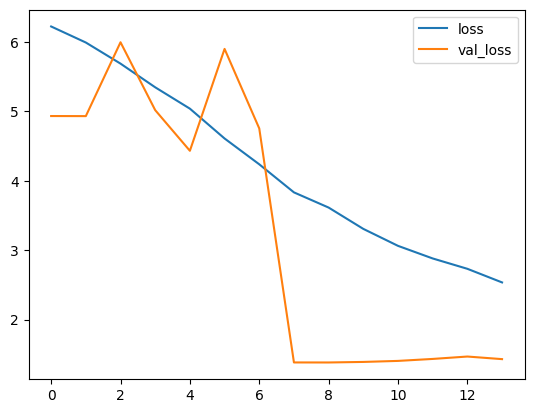

In [ ]:
history_custom_inception_rc_frame = pd.DataFrame(history_rc.history)
history_custom_inception_rc_frame.loc[:, ['loss', 'val_loss']].plot()

<Axes: >

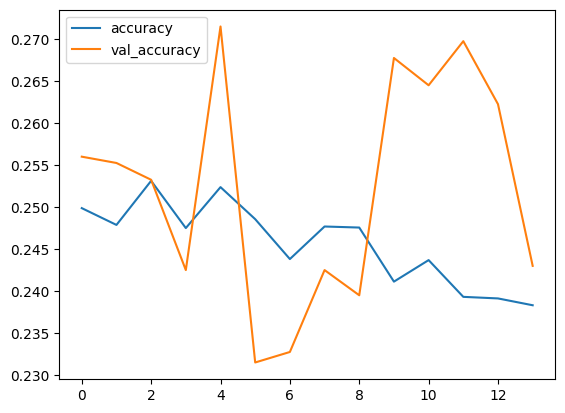

In [ ]:
#Loss & Accuracy Regular Classification
# Loss & accuracy of regular model
history_custom_inception_rc_frame = pd.DataFrame(history_rc.history)
history_custom_inception_rc_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [ ]:
# Convert true test labels to integers
y_test_int = np.argmax(y_test, axis=1)

In [ ]:
'''# Convert true test labels to integers
y_test_int = np.argmax(y_test, axis=1)

# Evaluate on test set
testeval = custom_inception_model.evaluate(x_test, y_test_int, verbose=2)

# Print performance metrics (loss and accuracy)
print("Test Loss:", testeval[0])
print("Test Accuracy:", testeval[1])

In [ ]:
#Results on Test Set
y_test_int = np.argmax(y_test, axis=1)
# Evaluate on test set
testeval = custom_inception_model_rc.evaluate(x_test, y_test, verbose=2)

# Printing performance metrics (loss and accuracy)
print("Test Loss:", testeval[0])
print("Test Accuracy:", testeval[1])


497/497 - 113s - loss: 1.2829 - accuracy: 0.0565 - 113s/epoch - 227ms/step
Test Loss: 1.2829036712646484
Test Accuracy: 0.056513529270887375


In [ ]:
'''params = {
    'base_score': 0.5,
    'booster': 'gbtree',
    'colsample_bylevel': 1,
    'colsample_bynode': 1,
    'learning_rate': 0.1,
    'max_delta_step': 0,
    'max_depth': 6,
    'min_child_weight': 1,
    'missing': 1,
    'n_estimators': 100,
    'n_jobs': -1,
    'nthread': None,
    'random_state': 1855,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'scale_pos_weight': 1,
    'seed': None,
    'silent': None,
    'subsample': 1,
    'verbosity': 0,
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 7,
    # Set number of GPUs if available
    'n_gpus': 0,
    'predictor': 'gpu_predictor'
}

modelXG = XGBClassifier(**params)'''

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Scale the extracted features using min-max scaling
scaler = MinMaxScaler()
normalized_features_train = scaler.fit_transform(feature_extractor_Train)
normalized_features_test = scaler.transform(feature_extractor_test)

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 6, 9],
    'n_estimators': [100, 300, 500]
}

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=XGBClassifier(objective='multi:softmax', num_class=7, n_jobs=-1, verbosity=0), param_grid=param_grid, cv=3)
grid_search.fit(feature_extractor_Train,y_train_int)

# Get best hyperparameters
best_params = grid_search.best_params_

# Initialize XGBoost classifier with best hyperparameters
modelXG = XGBClassifier(**best_params)

# Train XGBoost model
modelXG.fit(feature_extractor_Train,y_train_int)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
#modelXG.fit(feature_extractor_Train,y_train_int)

In [ ]:
XG_test_pred = modelXG.predict(feature_extractor_test)

In [ ]:
y_test_int.shape


(15890,)

In [ ]:
XG_test_pred.shape

(15890,)

In [ ]:
targetnames = ["non_demented", "very_mild_demented", "moderate_demented", "mild_demented"]
print(classification_report(y_test_int, XG_test_pred, target_names=targetnames))

                    precision    recall  f1-score   support

      non_demented       0.93      0.57      0.70     13376
very_mild_demented       0.16      0.52      0.24      1415
 moderate_demented       0.13      0.35      0.19      1001
     mild_demented       0.07      0.24      0.11        98

          accuracy                           0.55     15890
         macro avg       0.32      0.42      0.31     15890
      weighted avg       0.80      0.55      0.63     15890



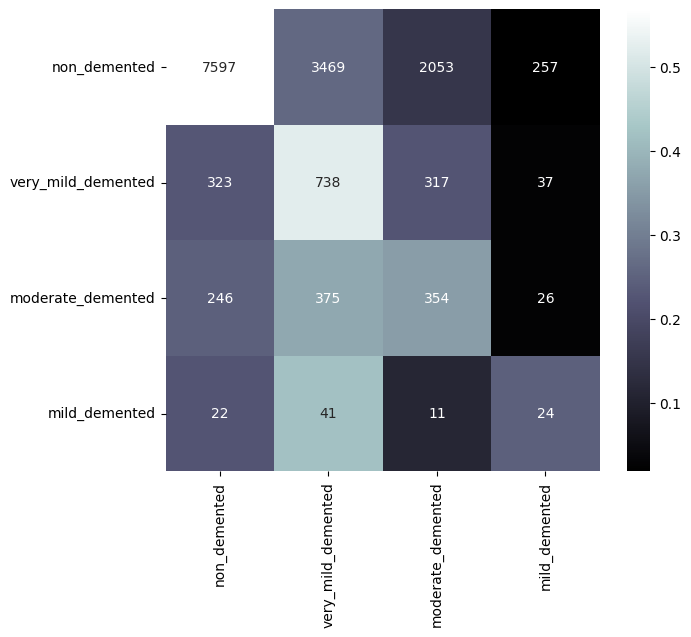

In [ ]:
def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)

cm = confusion_matrix(y_test_int,XG_test_pred)
plot_confusion_matrix(cm, targetnames)

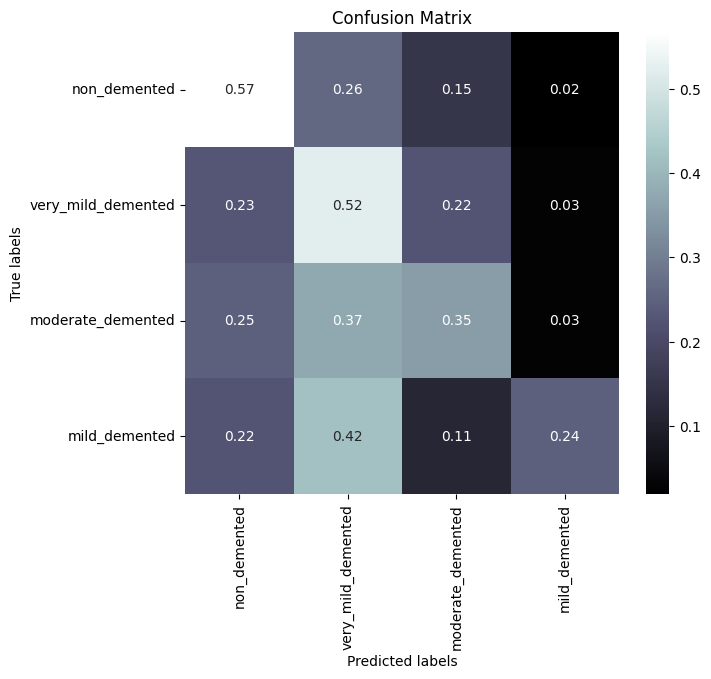

Class non_demented:
Sensitivity (True Positive Rate): 0.5679575358851675
Specificity (True Negative Rate): 0.7649164677804295

Class very_mild_demented:
Sensitivity (True Positive Rate): 0.5215547703180212
Specificity (True Negative Rate): 0.7316062176165803

Class moderate_demented:
Sensitivity (True Positive Rate): 0.35364635364635366
Specificity (True Negative Rate): 0.8400832829605749

Class mild_demented:
Sensitivity (True Positive Rate): 0.24489795918367346
Specificity (True Negative Rate): 0.9797365754812564

              precision    recall  f1-score   support

           0       0.93      0.57      0.70     13376
           1       0.16      0.52      0.24      1415
           2       0.13      0.35      0.19      1001
           3       0.07      0.24      0.11        98

    accuracy                           0.55     15890
   macro avg       0.32      0.42      0.31     15890
weighted avg       0.80      0.55      0.63     15890



In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(norm_cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap=cmap)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Calculate sensitivity and specificity for each class
    for i in range(len(classes)):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        fp = np.sum(cm[:, i]) - tp
        tn = np.sum(cm) - (tp + fn + fp)

        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        print(f"Class {classes[i]}:")
        print("Sensitivity (True Positive Rate):", sensitivity)
        print("Specificity (True Negative Rate):", specificity)
        print()

# Assuming y_test1 contains the true labels and predictions_test contains the predicted labels
cm = confusion_matrix(y_test_int, XG_test_pred)
plot_confusion_matrix(cm, targetnames)

# Print classification report
print(classification_report(y_test_int, XG_test_pred))